In [2]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
from alive_progress import alive_bar
from project_package.generate_pop import generate_initial_pop_unlinked, generate_random_fisherlog_pop_unlinked,generate_random_fisherlog_pop_binomial_tree, SymPop
from project_package.run_model import update_pop3,run_until_fixation3
from project_package.simplify import subsample_pop,merge_graphs,remove_empty_leaves_and_rescale_edges

from project_package.plot import visualize_pop

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Merge graphs

## Toy example

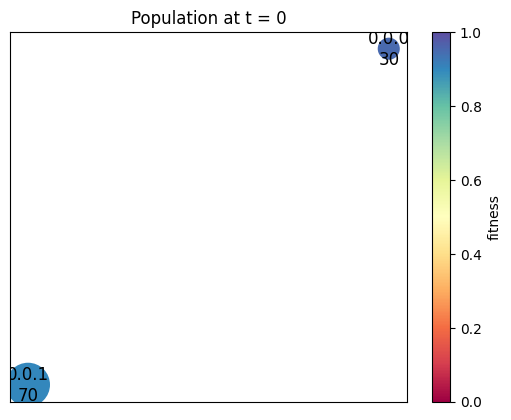

In [65]:
np.random.seed(666)
mutation_rate=0.005
growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

new_avail_id='0.0.0'
masterG=generate_initial_pop_unlinked(fitnesses,abundances)
masterG=nx.relabel_nodes(masterG, {0:'0.0.0',1:'0.0.1'})

visualize_pop(masterG)

50
100
150


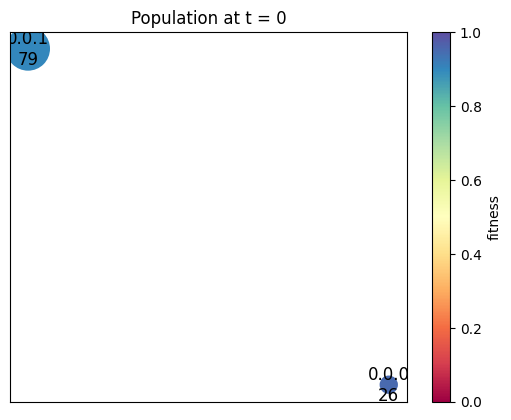

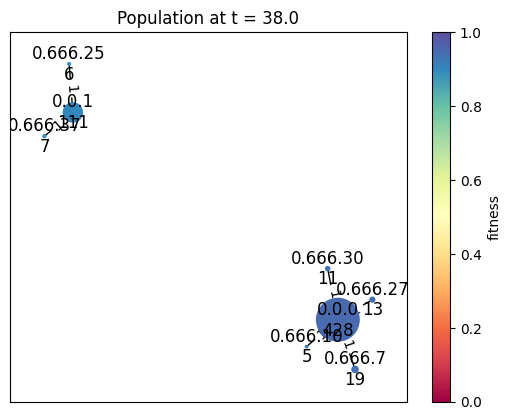

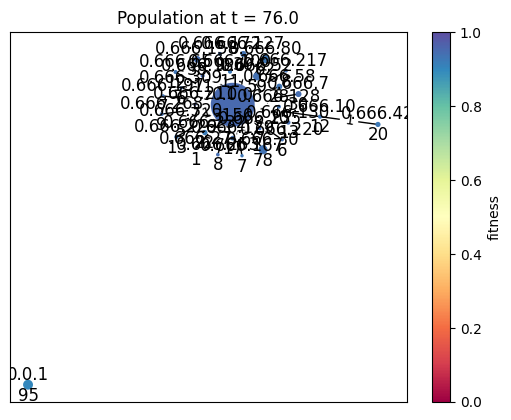

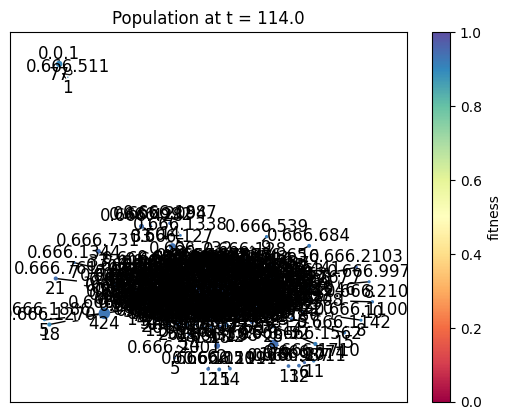

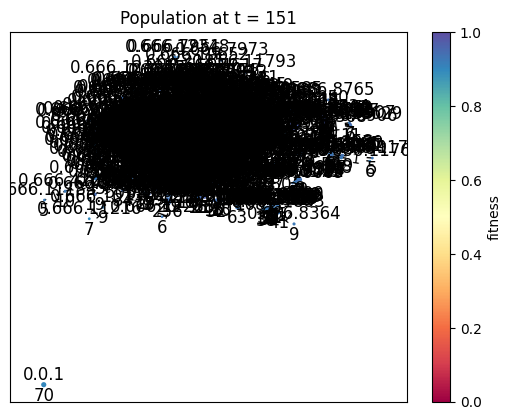

In [120]:
np.random.seed(666)
G_666=masterG.copy()

runtime=5
new_avail_id='0.666.0'

results_666=run_until_fixation3(G_666,mutation_rate,runtime, new_avail_id, stop_when_fixed=True,verbose=50, growth_factor=growth_factor)
for i in [0,np.round(len(results_666)/4),np.round(len(results_666)/2),np.round(3*len(results_666)/4),len(results_666)-1]:
    plt.figure()
    visualize_pop(results_666[i],i,view_edge_labels=True,view_node_labels=True,abundance_threshold=5)
    plt.show(block=False)

50


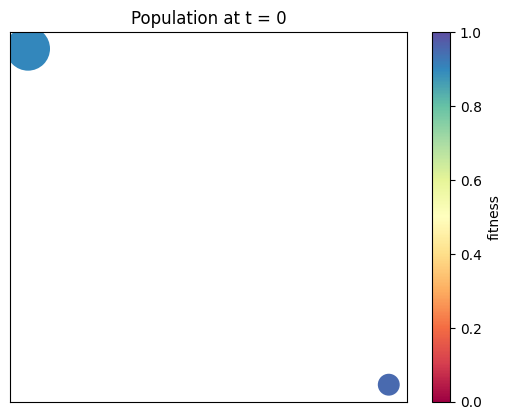

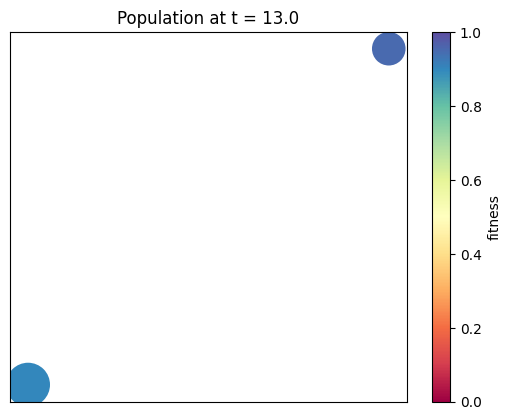

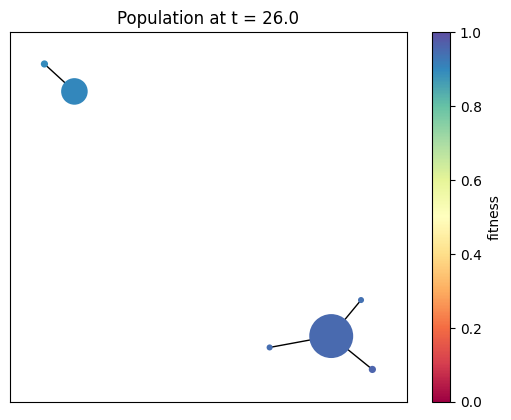

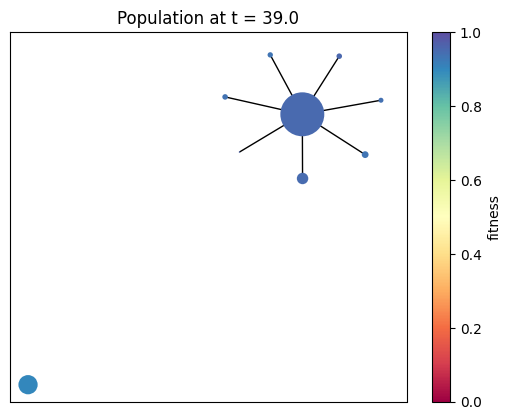

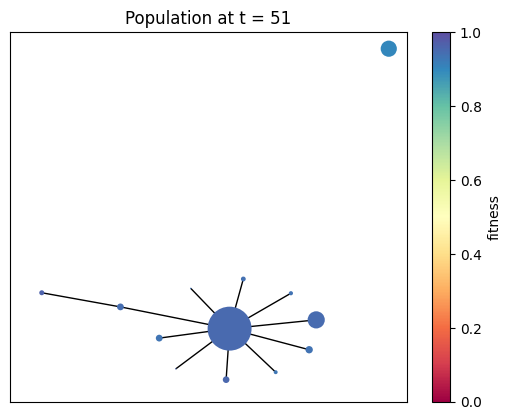

In [119]:
np.random.seed(999)
mutation_rate=0.005
growth_factor=1.05
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance

G_999=masterG.copy()

runtime=5
new_avail_id='0.999.0'

results_999=run_until_fixation3(G_999,mutation_rate,runtime, new_avail_id, stop_when_fixed=True,verbose=50, growth_factor=growth_factor)
for i in [0,np.round(len(results_999)/4),np.round(len(results_999)/2),np.round(3*len(results_999)/4),len(results_999)-1]:
    plt.figure()
    visualize_pop(results_999[i],i,view_edge_labels=False,view_node_labels=False,abundance_threshold=5)
    plt.show(block=False)

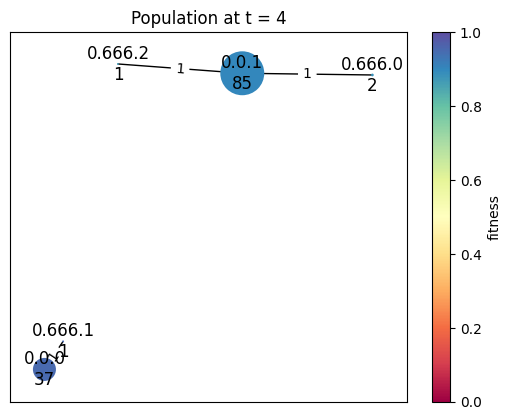

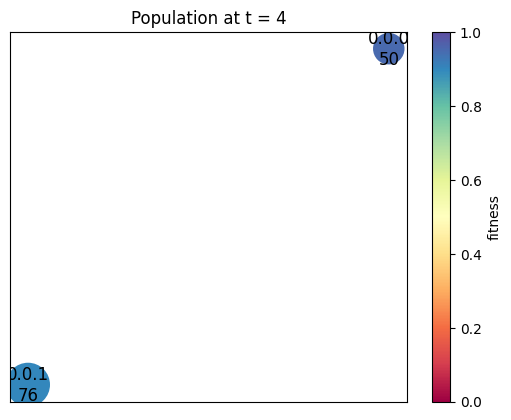

In [121]:
i=4

for res in [results_666, results_999]:
    plt.figure()
    visualize_pop(res[i],i,view_edge_labels=True,view_node_labels=True,abundance_threshold=0)
    plt.show(block=False)

[('0.0.0', {'abundance': 137, 'fitness': 0.95}), ('0.0.1', {'abundance': 237, 'fitness': 0.9}), ('0.666.0', {'abundance': 2, 'fitness': 0.8811807824813518}), ('0.666.1', {'abundance': 1, 'fitness': 0.9525327038935059}), ('0.666.2', {'abundance': 1, 'fitness': 0.8676503123308376})]


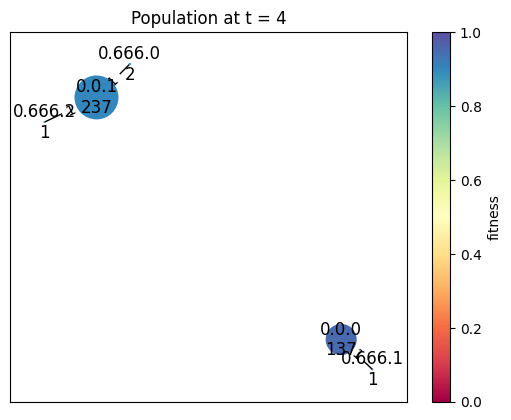

In [195]:

i=4
Graph0=results_999[i]
Graph1=results_666[i]
Graph2=results_999[i]
Graph_list=[Graph0,Graph1,Graph2]

merged_Graph=merge_node_abundances(Graph_list)

print(merged_Graph.nodes(data=True))

visualize_pop(merged_Graph,i,view_edge_labels=True,view_node_labels=True,abundance_threshold=0)


## Realistic example

### test1 starting from unlinked strains

In [205]:
# np.random.seed(666)
mutation_rate=0.00000001
runtime=20000000 #max number of generations
pop_size_thr=1E10
growth_factor=1.20
steady_state_runtime=200
sampling_rate=20

freelivingG=generate_random_fisherlog_pop_unlinked(i=2000) #n=individuals, i=strains
print(SymPop(freelivingG).pop_size)
df_diversity=pd.DataFrame([])
res_graphs={}
for iteration in range(5): # here different iterations are akin to different individual hosts/sub-populations
        
    #Set new host and subsample from free-living population
    new_avail_id='1.'+str(iteration)+'.0'
    subsampleG=subsample_pop(freelivingG,20)

    # Grow host
    results=run_until_fixation3(subsampleG, mutation_rate, runtime, new_avail_id, growth_factor=growth_factor, stop_when_fixed=True, pop_size_thr=pop_size_thr, verbose=0, t=0,sampling_rate=sampling_rate)
    print('len(results)',len(results)) 
    
    # Keep steady population in host for another symbiont 200 generations
    t=list(results.keys())[-1]
    print('t',t)
    
    results.update(run_until_fixation3(results[list(results.keys())[-1]], mutation_rate, t+steady_state_runtime, new_avail_id, growth_factor=1, stop_when_fixed=True, pop_size_thr=np.inf, verbose=50, t=t, sampling_rate=sampling_rate))  
    print(list(results.keys())[-1])    
    ###########
    res_graphs[iteration]=results
    for i in results.keys():
        G=SymPop(results[i])
    
        richness=G.richness
        pop_size=G.pop_size
        tmp=pd.DataFrame.from_dict({i:[richness,pop_size]}, orient='index',columns=['richness','total_pop_size'])
        tmp['generation']=i
        tmp['iteration']=iteration
        df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)


print('len(df_diversity)',len(df_diversity) )

79003
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
len(df_diversity) 90


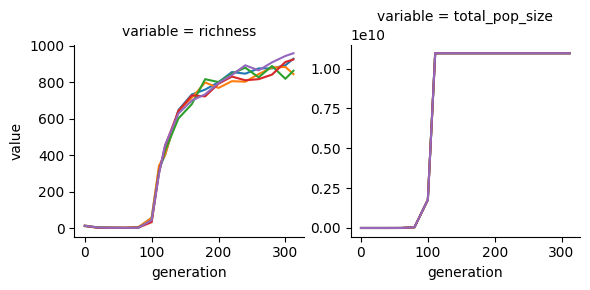

In [204]:
df_diversity=df_diversity.melt(id_vars=['iteration','generation'])

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False,hue='iteration')
g.map_dataframe(sns.lineplot, x="generation",y='value')

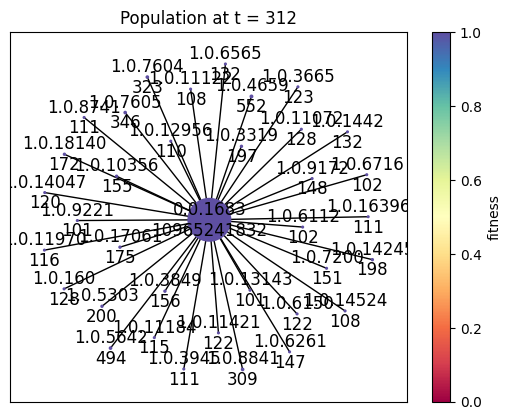

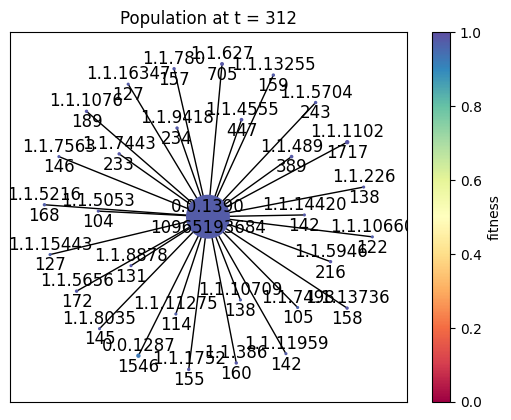

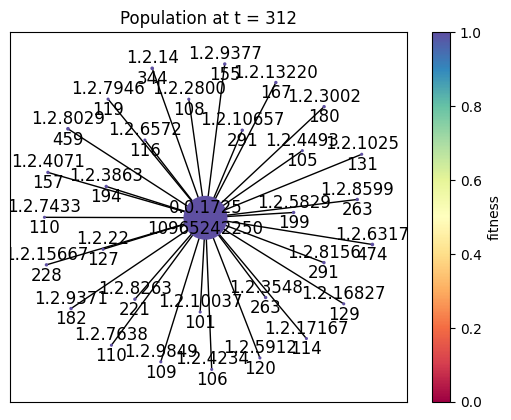

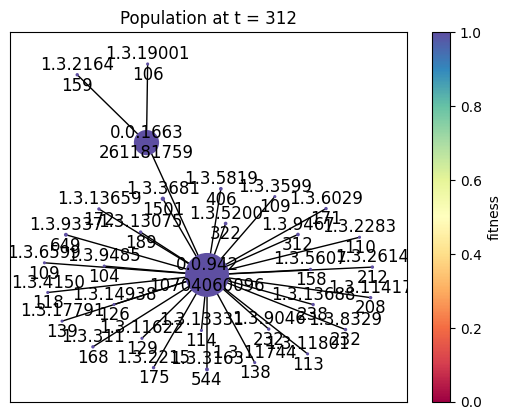

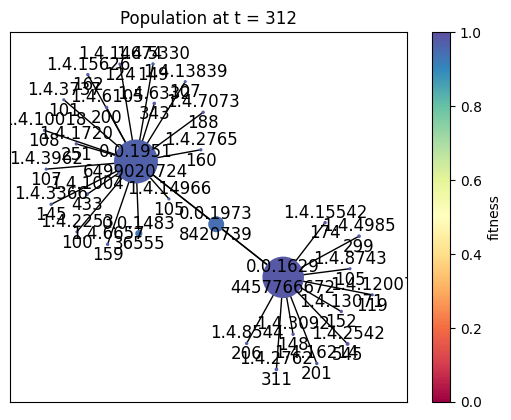

In [212]:
for i in range(5):
    plt.figure()
    visualize_pop(res_graphs[i][312],312,view_edge_labels=False,view_node_labels=True,abundance_threshold=100)
    plt.show(block=False)

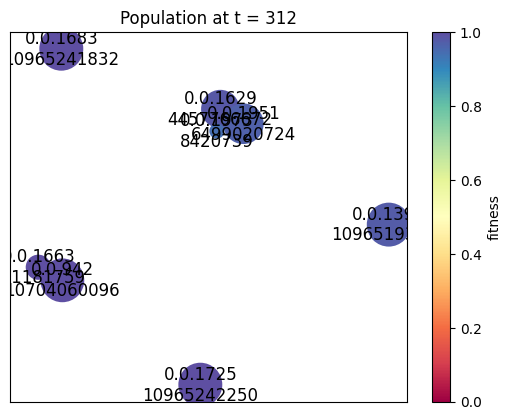

In [221]:
Graph_list=[res_graphs[i][312] for i in range(5)]
merged_Graph=merge_graphs(Graph_list)
merged_Graph=remove_empty_leaves_and_rescale_edges(merged_Graph)


plt.figure()
visualize_pop(merged_Graph,312,view_edge_labels=False,view_node_labels=True,abundance_threshold=51000)
plt.show(block=False)

# Subsample graph

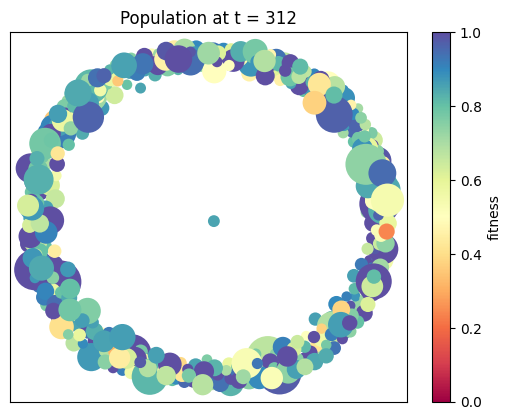

In [234]:
Graph_list=[subsample_pop(res_graphs[i][312],700) for i in range(5)]
merged_Graph=merge_graphs([freelivingG]+Graph_list)
merged_Graph=remove_empty_leaves_and_rescale_edges(merged_Graph)


plt.figure()
visualize_pop(merged_Graph,312,view_edge_labels=False,view_node_labels=False,abundance_threshold=50)
plt.show(block=False)

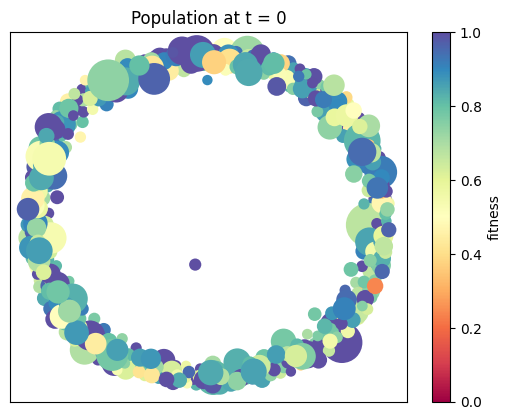

In [235]:
plt.figure()
visualize_pop(freelivingG,0,view_edge_labels=False,view_node_labels=False,abundance_threshold=50)
plt.show(block=False)

## test2 starting from phylogenetically related strains

72386


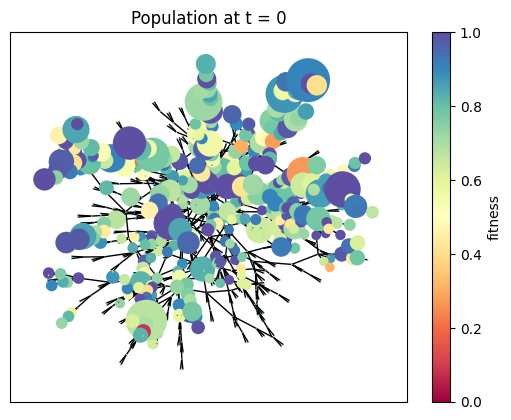

72386
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
max population size reached:  10000000000.0
len(results) 7
t 111
150
200
250
300
max runtime reached:  311
312
len(df_diversity) 90


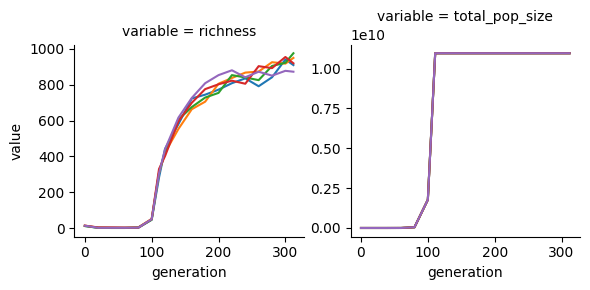

In [238]:
# np.random.seed(666)
mutation_rate=0.00000001
runtime=20000000 #max number of generations
pop_size_thr=1E10
growth_factor=1.20
steady_state_runtime=200
sampling_rate=20

freelivingG=generate_random_fisherlog_pop_binomial_tree(i=2000) #n=individuals, i=strains
plt.figure()
visualize_pop(freelivingG,0,view_edge_labels=False,view_node_labels=False,abundance_threshold=50)
plt.show(block=False)

print(SymPop(freelivingG).pop_size)
df_diversity=pd.DataFrame([])
res_graphs={}
for iteration in range(5):
        
    #Set new host and subsample from free-living population
    new_avail_id='1.'+str(iteration)+'.0'
    subsampleG=subsample_pop(freelivingG,20)

    # Grow host
    results=run_until_fixation3(subsampleG, mutation_rate, runtime, new_avail_id, growth_factor=growth_factor, stop_when_fixed=True, pop_size_thr=pop_size_thr, verbose=0, t=0,sampling_rate=sampling_rate)
    print('len(results)',len(results)) 
    
    # Keep steady population in host for another symbiont 200 generations
    t=list(results.keys())[-1]
    print('t',t)
    
    results.update(run_until_fixation3(results[list(results.keys())[-1]], mutation_rate, t+steady_state_runtime, new_avail_id, growth_factor=1, stop_when_fixed=True, pop_size_thr=np.inf, verbose=50, t=t, sampling_rate=sampling_rate))  
    print(list(results.keys())[-1])    
    ###########
    res_graphs[iteration]=results
    for i in results.keys():
        G=SymPop(results[i])
    
        richness=G.richness
        pop_size=G.pop_size
        tmp=pd.DataFrame.from_dict({i:[richness,pop_size]}, orient='index',columns=['richness','total_pop_size'])
        tmp['generation']=i
        tmp['iteration']=iteration
        df_diversity=pd.concat([df_diversity, tmp], ignore_index=True)


print('len(df_diversity)',len(df_diversity) )

df_diversity=df_diversity.melt(id_vars=['iteration','generation'])

g = sns.FacetGrid(df_diversity, col="variable",sharex=True, sharey=False,hue='iteration')
g.map_dataframe(sns.lineplot, x="generation",y='value')

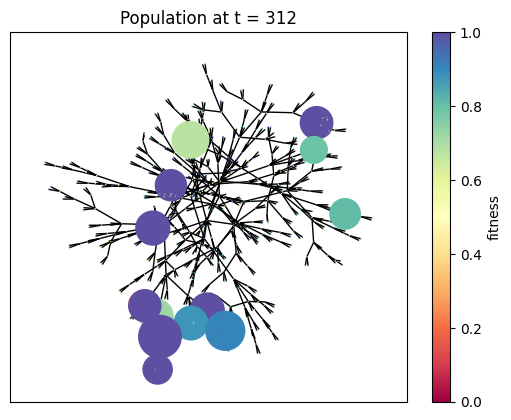

In [244]:
Graph_list=[subsample_pop(res_graphs[i][312],700) for i in range(5)]
merged_Graph=merge_graphs([freelivingG]+Graph_list)
merged_Graph=remove_empty_leaves_and_rescale_edges(merged_Graph)


plt.figure()
visualize_pop(merged_Graph,312,view_edge_labels=False,view_node_labels=False,abundance_threshold=500)
plt.show(block=False)

# Run one generation of host population (Subsample, grow_and_steady, and merge function)

100
finished
it took 0.41547703742980957 seconds


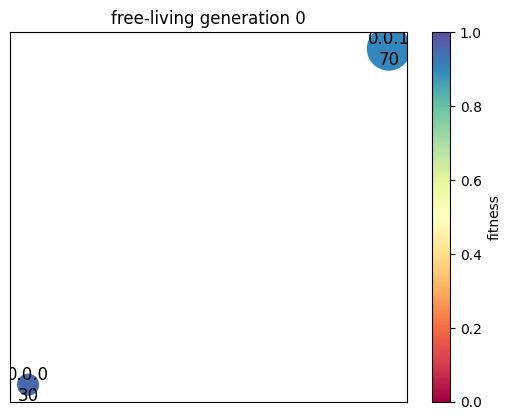

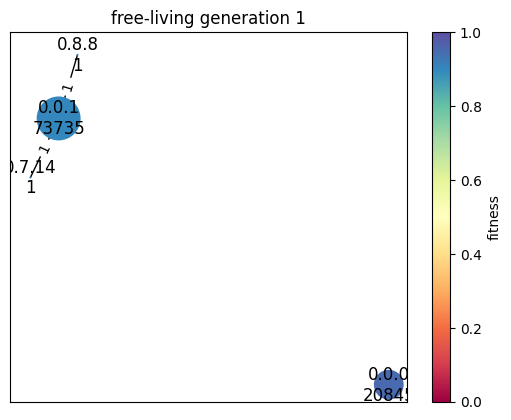

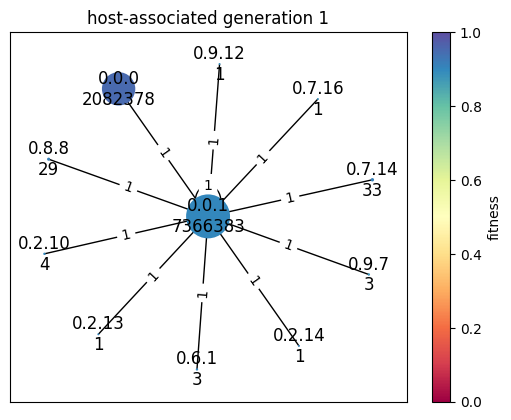

In [11]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
from project_package.generate_pop import generate_initial_pop_unlinked
from project_package.update_pop import update_pop3
from project_package.run_model import grow_and_steady_from_freeliving
from project_package.plot import visualize_pop

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
# %autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-7
growth_factor=1.5
steady_state_runtime=1E2
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=2
host_pop_gen=1
escape_rate=1E-2

## init tree
fitnesses=[0.95,0.9] # allele_id:fitness
abundances=[30,70] # allele_id:abundance
freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG

# ## init tree log-fisher
# freelivingG=generate_random_fisherlog_pop_unlinked(i=10) #n=individuals, i=strains
# freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(10)]))

print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


def run_generation_of_host_pop(freelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                     mutation_rate, steady_state_runtime,
                     max_runtime, pop_size_thr=pop_size_thr, growth_factor=growth_factor,
                     stop_when_fixed=True, simplify=simplify,
                     verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=1):
    
    Graph_list_hostassociated=[]
    Graph_list_escapees=[]

    ### parallel phase ###
    
    args=[{'freelivingG':freelivingG,'host_pop_gen':host_pop_gen, 'host_id':host_id,
          'infection_sym_count':infection_sym_count, 'steady_state_runtime':steady_state_runtime,
          'mutation_rate':mutation_rate,'max_runtime':max_runtime, 
          'growth_factor':growth_factor,'pop_size_thr':pop_size_thr,
          'escape_rate':escape_rate,'sampling_rate':1,'verbose':verbose} for host_id in range(n_worms)]

    with multiprocessing.Pool(processes=nthreads) as pool:
        Graph_lists=pool.map(grow_and_steady_from_freeliving,args)
    
    Graph_list_hostassociated,Graph_list_escapees=map(list, zip(*Graph_lists)) 

    # for i in range(len(Graph_list_hostassociated)):
    #     plt.figure()
    #     graph=Graph_list_hostassociated[i]
    #     visualize_pop(graph,replace_title='host '+str(i))
    
    # get the host-associated symbiont meta-pop

    merged_Graph_hostassociated=merge_graphs(Graph_list_hostassociated)
    merged_Graph_hostassociated=remove_empty_leaves_and_rescale_edges(merged_Graph_hostassociated)

    # get the new free-living pop (after symbionts escape worm)
    merged_Graph_freeliving=merge_graphs([freelivingG]+Graph_list_escapees)
    merged_Graph_freeliving=remove_empty_leaves_and_rescale_edges(merged_Graph_freeliving)


    return(merged_Graph_hostassociated, merged_Graph_freeliving)


###############################

start_time=time.time()


host_pop_gen=0
myfreelivingG=freelivingG.copy()
merged_Graph_hostassociated, merged_Graph_freeliving=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                     mutation_rate, steady_state_runtime,
                     max_runtime, growth_factor=growth_factor,
                     stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                     verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=4)
    
print('finished')

print('it took', time.time()-start_time, 'seconds')


plt.figure()
visualize_pop(freelivingG,replace_title='free-living generation 0')

plt.figure()
visualize_pop(merged_Graph_freeliving,replace_title='free-living generation 1')

plt.figure()
visualize_pop(merged_Graph_hostassociated,replace_title='host-associated generation 1')


# Run toy example: 10 trials of 100 generation of host population

In [167]:
import pandas as pd
import sys
sys.path.append("/Users/maeva/Desktop/Modeling_trophosome/src/")
from project_package.generate_pop import generate_initial_pop_unlinked
from project_package.update_pop import update_pop3
from project_package.run_model import grow_and_steady_from_freeliving
from project_package.plot import visualize_pop

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from alive_progress import alive_bar

import time


# import seaborn as sns
%matplotlib inline
%reload_ext autoreload
# %autoreload 2
# np.random.seed(666)

## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

## params grow_and_steady
mutation_rate=1E-9
growth_factor=1.5
steady_state_runtime=1E2
max_runtime=np.inf
pop_size_thr=1E6
simplify=1
verbose=0
sampling_rate=1

## params run_host_pop_gen
n_worms=10
infection_sym_count=2
host_pop_gen=1
escape_rate=1E-2

## init tree
# fitnesses=[0.95,0.9] # allele_id:fitness
# abundances=[3000000,7000000] # allele_id:abundance
# freelivingG=generate_initial_pop_unlinked(fitnesses,abundances)
# freelivingG=nx.relabel_nodes(freelivingG, {0:'0.0.0',1:'0.0.1'})
# time_series_freeliving[0]=freelivingG

## init tree log-fisher
freelivingG=generate_random_fisherlog_pop_unlinked(i=10) #n=individuals, i=strains
freelivingG=nx.relabel_nodes(freelivingG, dict([[i,'0.0.'+str(i)] for i in range(10)]))

print(SymPop(freelivingG).pop_size)
time_series_freeliving[0]=freelivingG


def run_generation_of_host_pop(freelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                     mutation_rate, steady_state_runtime,
                     max_runtime, pop_size_thr=pop_size_thr, growth_factor=growth_factor,
                     stop_when_fixed=True, simplify=simplify,
                     verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=1):
    
    Graph_list_hostassociated=[]
    Graph_list_escapees=[]

    ### parallel phase ###
    
    args=[{'freelivingG':freelivingG,'host_pop_gen':host_pop_gen, 'host_id':host_id,
          'infection_sym_count':infection_sym_count, 'steady_state_runtime':steady_state_runtime,
          'mutation_rate':mutation_rate,'max_runtime':max_runtime, 
          'growth_factor':growth_factor,'pop_size_thr':pop_size_thr,
          'escape_rate':escape_rate,'sampling_rate':1,'verbose':verbose} for host_id in range(n_worms)]

    with multiprocessing.Pool(processes=nthreads) as pool:
        Graph_lists=pool.map(grow_and_steady_from_freeliving,args)
    
    Graph_list_hostassociated,Graph_list_escapees=map(list, zip(*Graph_lists)) 

    # for i in range(len(Graph_list_hostassociated)):
    #     plt.figure()
    #     graph=Graph_list_hostassociated[i]
    #     visualize_pop(graph,replace_title='host '+str(i))
    
    # get the host-associated symbiont meta-pop

    merged_Graph_hostassociated=merge_graphs(Graph_list_hostassociated)
    merged_Graph_hostassociated=remove_empty_leaves_and_rescale_edges(merged_Graph_hostassociated)

    # get the new free-living pop (after symbionts escape worm)
    merged_Graph_freeliving=merge_graphs([freelivingG]+Graph_list_escapees)
    merged_Graph_freeliving=remove_empty_leaves_and_rescale_edges(merged_Graph_freeliving)


    return(merged_Graph_hostassociated, merged_Graph_freeliving)


###############################
## init results objects    
time_series_freeliving={}
time_series_hostassociated={}

start_time=time.time()

with alive_bar((int(1E2)+1) * 10 ,force_tty=True) as bar:
    for trial in range(10):
        host_pop_gen=0
        time_series_freeliving[trial]=[freelivingG]
        time_series_hostassociated[trial]=[freelivingG]
        myfreelivingG=freelivingG.copy()
    
        for host_pop_gen in range(1,int(1E2)+1):
        
            merged_Graph_hostassociated, merged_Graph_freeliving=run_generation_of_host_pop(myfreelivingG, n_worms, infection_sym_count,host_pop_gen,escape_rate,
                                 mutation_rate, steady_state_runtime,
                                 max_runtime, growth_factor=growth_factor,
                                 stop_when_fixed=True, pop_size_thr=pop_size_thr, simplify=simplify,
                                 verbose=verbose, t=0,sampling_rate=sampling_rate,nthreads=4)
            
            time_series_hostassociated[trial]+=[merged_Graph_hostassociated]
            time_series_freeliving[trial]+=[merged_Graph_freeliving]
            myfreelivingG=merged_Graph_freeliving
            
            bar() 
print('finished')

print('it took', time.time()-start_time, 'seconds')


# plt.figure()
# visualize_pop(freelivingG,replace_title='free-living generation 0')

# plt.figure()
# visualize_pop(merged_Graph_freeliving,replace_title='free-living generation 1')

# plt.figure()
# visualize_pop(merged_Graph_hostassociated,replace_title='host-associated generation 1')


131
|███████████████████████████████████████▋⚠︎ (!) 1000/1010 [99%] in 13:15.6 (1.26/▂▄▆ 387/1010 [38%] in 5:30 (~8:51, 1.
finished
it took 795.6093637943268 seconds


     pop_size  richness      metapop trial
97   10183191        12  free-living     9
98   10288171        12  free-living     9
99   10393151        12  free-living     9
100  10498131        12  free-living     9


<Axes: xlabel='None', ylabel='richness'>

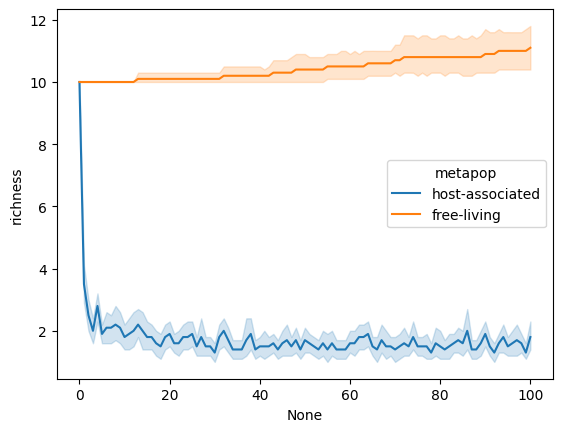

In [210]:
from project_package.generate_pop import SymPop
import seaborn as sns

df=pd.DataFrame()
for trial in time_series_hostassociated.keys():

    df2=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'host-associated',str(trial)] for G in time_series_hostassociated[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df2])

    df3=pd.DataFrame([[SymPop(G).pop_size,SymPop(G).richness,'free-living',str(trial)] for G in time_series_freeliving[trial]],
                            columns=['pop_size','richness','metapop','trial'])
    df=pd.concat([df, df3])


print(df[-4:])
sns.lineplot(data=df,x=df.index,y='richness',hue='metapop')